# Utilizing Decision Tree to reverse engineer the lifecycle of a sale
---

## Content
- Overview
- Model Selection
- Data Loading with our model
- Data Preparation for training
- Studies
    - Perform Decision Tree model
    - Model Evaluations
- Summary

## Overview

To align with the business goal, the utopian state is of course finding a model to classify whether a lead can generate a sale or not. However, this is a classic "credit card fraud problem" in the data science field, where the data set is extremely imbalanced, we **need to pivot into a different perspective** towards the problem.

Instead of forcing ourself into a subpar imbalanced random forest model or SMOTE, we will deep dive into each sales driver variable, and **optimize the inter-relationships** between `email_open`, `web_visit`, `webcase_attendee` and `marketing_engaged`. 

## Model Selection

We will **only look at the successful** sales data.

First, we will continue to utilize the twenty percentile as `effective sale` as our metrics, because the amount of dollar sold by each mutual fund is highly dependant on local economic status,  *(i.e. if a person only has USD 100, we will not be able to sell a USD 30,000 worth of car.)*

Second, we want to study all the combinations by using `conditional probabilities` in different sequential orders for our 4 driver variables. This will involve a series of `Bayesian statistical studies`.

By `reversing a decision tree`, we will be able to see all the sales lead roadmaps.

### Example:
1. Bundling `[sale with email]` vs `[sale without email]` as our Y observations.
2. Utilizing the remaining 3 variables as training X observations
3. Summarizing the tree branches for studies.

---
## Data loading with custom data model

The following blocks of code will utilize our modulized data model from previous exploration process. 

In [1]:
# Importing custom library
from DataModels.models import data_processing

# Importing other libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import Counter

# Importing machine learning libraries
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [2]:
# Locating the data and using the data model we have created
folder_path = "RawData"
houseOfData = data_processing.house_of_data(folder_path)

In [3]:
# Trigger the enrichment function do process our data
houseOfData.enrichment()
bdf = houseOfData._enriched_df

bdf.head(5)

,broker_name,city_state,territory,fund_category,firm_x_sales,total_industry_sales,email_open,web_visit,webcast_attendee,marketing_engaged,source_file,state,i_or_w,effective_sale,driver_pattern
0,Broker0001,"OVERLAND PARK, KS",I47,Intermediate-Term Bond,0.0,179227.86,0,1,0,1,RawData\Analytics_Data1.txt,KS,1,0,"(0, 1, 0, 1)"
1,Broker0002,"GREAT NECK, NY",I48,Short-Term Bond,0.0,21956.00,1,1,1,1,RawData\Analytics_Data1.txt,NY,1,0,"(1, 1, 1, 1)"
2,Broker0003,"PITTSBURGH, PA",I09,Diversified Emerging Mkts,0.0,53223.03,0,0,0,0,RawData\Analytics_Data1.txt,PA,1,0,"(0, 0, 0, 0)"
3,Broker0004,"FAIRFIELD, CT",I25,Foreign Large Blend,0.0,595799.49,1,0,0,1,RawData\Analytics_Data1.txt,CT,1,0,"(1, 0, 0, 1)"
4,Broker0005,"LAWTON, OK",W27,Bank Loan,0.0,0.00,1,0,0,1,RawData\Analytics_Data1.txt,OK,0,0,"(1, 0, 0, 1)"


---
## Data Preparation for training



In [4]:
# Loading in the driver columns from data processing
drivercol = data_processing.driver_columns

for i in drivercol:
    col_name = "S_" + i
    fmask =  bdf[i] == 1
    smask = bdf['effective_sale'] == 1
    
    bdf[col_name] = 0
    bdf.loc[fmask&smask, col_name] = 1

In [5]:
bdf.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1721310 entries, 0 to 1721309
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   broker_name           1721310 non-null  object 
 1   city_state            1721310 non-null  object 
 2   territory             1721310 non-null  object 
 3   fund_category         1721310 non-null  object 
 4   firm_x_sales          1721310 non-null  float64
 5   total_industry_sales  1721310 non-null  float64
 6   email_open            1721310 non-null  int64  
 7   web_visit             1721310 non-null  int64  
 8   webcast_attendee      1721310 non-null  int64  
 9   marketing_engaged     1721310 non-null  int64  
 10  source_file           1721310 non-null  object 
 11  state                 1721310 non-null  object 
 12  i_or_w                1721310 non-null  int64  
 13  effective_sale        1721310 non-null  int64  
 14  driver_pattern        1721310 non-

In [6]:
# Creating new columns to binary label a sale with the corresponding driver
for i in bdf.columns:
    if "S_" in i:
        print(i, bdf[i].sum())
    else:
        pass

S_email_open 86310
S_web_visit 74284
S_webcast_attendee 40071
S_marketing_engaged 99067


### Study - Email Open

In [7]:
X = bdf.loc[(bdf['effective_sale'] == 1),['web_visit','webcast_attendee','marketing_engaged']]
X

,web_visit,webcast_attendee,marketing_engaged
8,1,0,1
38,1,1,1
44,0,0,0
45,0,0,1
57,1,1,1
...,...,...,...
1721240,0,0,0
1721252,0,0,0
1721289,1,0,1
1721300,0,1,1


In [8]:
# Define target vector and look at how it's shaped
y = np.array(bdf.loc[(bdf['effective_sale'] == 1),'S_email_open'])
y[:5]

array([1, 1, 0, 1, 1], dtype=int64)

#### Email Open - Creating a train test split

First, we have to divide the data into 2 for training and testing purposes. Since the driver variables are all binary, we are not going to deploy any scalers in this model.

In [9]:
# Splitting up the training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

---
#### Email Open - Perform Decision Tree model

In [10]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train, y_train)

# Making predictions using the testing data
# This is for the evaluation process
predictions = model.predict(X_test)

---
#### Email Open - Model Evaluations

In [11]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [12]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13555,3145
Actual 1,0,21658


Accuracy Score : 0.91800928098441
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     16700
           1       0.87      1.00      0.93     21658

    accuracy                           0.92     38358
   macro avg       0.94      0.91      0.91     38358
weighted avg       0.93      0.92      0.92     38358



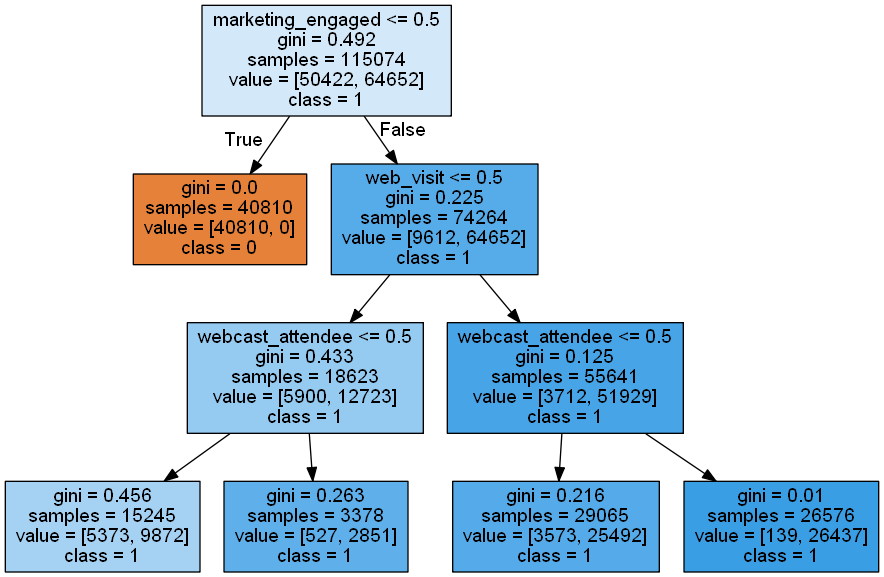

In [13]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

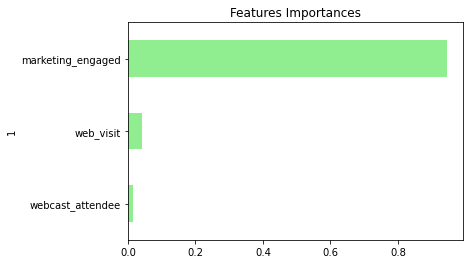

In [14]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)



### Study - Web Visit

In [15]:
X = bdf.loc[(bdf['effective_sale'] == 1),['email_open','webcast_attendee','marketing_engaged']]
X

,email_open,webcast_attendee,marketing_engaged
8,1,0,1
38,1,1,1
44,0,0,0
45,1,0,1
57,1,1,1
...,...,...,...
1721240,0,0,0
1721252,0,0,0
1721289,1,0,1
1721300,1,1,1


In [16]:
# Define target vector and look at how it's shaped
y = np.array(bdf.loc[(bdf['effective_sale'] == 1),'S_web_visit'])
y[:5]

array([1, 1, 0, 0, 1], dtype=int64)

#### Web Visit - Creating a train test split

In [17]:
# Splitting up the training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### Web Visit - Perform Decision Tree model

In [18]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train, y_train)

# Making predictions using the testing data
# This is for the evaluation process
predictions = model.predict(X_test)

#### Web Visit - Model Evaluations

In [19]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [20]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15485,4230
Actual 1,1215,17428


Accuracy Score : 0.8580478648521821
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     19715
           1       0.80      0.93      0.86     18643

    accuracy                           0.86     38358
   macro avg       0.87      0.86      0.86     38358
weighted avg       0.87      0.86      0.86     38358



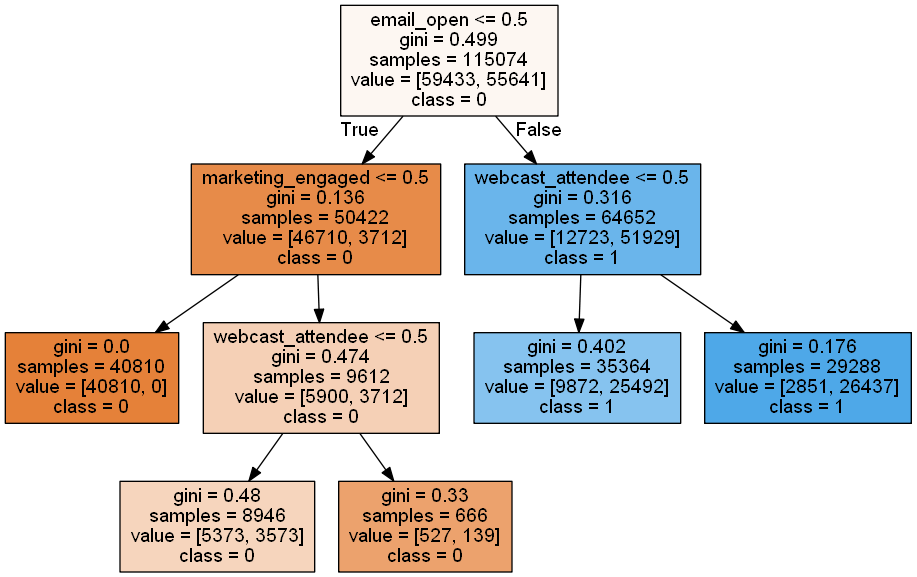

In [21]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

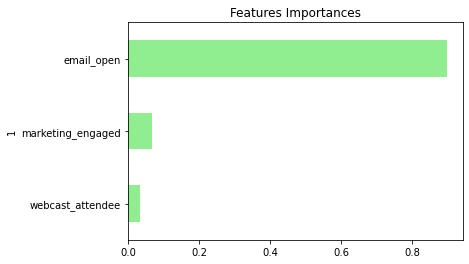

In [22]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)



### Study - Webcast Attendee

In [23]:
X = bdf.loc[(bdf['effective_sale'] == 1),['email_open','web_visit','marketing_engaged']]
X

,email_open,web_visit,marketing_engaged
8,1,1,1
38,1,1,1
44,0,0,0
45,1,0,1
57,1,1,1
...,...,...,...
1721240,0,0,0
1721252,0,0,0
1721289,1,1,1
1721300,1,0,1


In [24]:
# Define target vector and look at how it's shaped
y = np.array(bdf.loc[(bdf['effective_sale'] == 1),'S_webcast_attendee'])
y[:5]

array([0, 1, 0, 0, 1], dtype=int64)

#### Webcast Attendee - Creating a train test split

In [25]:
# Splitting up the training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### Webcast Attendee - Perform Decision Tree model

In [26]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train, y_train)

# Making predictions using the testing data
# This is for the evaluation process
predictions = model.predict(X_test)

#### Webcast Attendee - Model Evaluations

In [27]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [28]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,19739,8502
Actual 1,1191,8926


Accuracy Score : 0.7473017362740497
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     28241
           1       0.51      0.88      0.65     10117

    accuracy                           0.75     38358
   macro avg       0.73      0.79      0.73     38358
weighted avg       0.83      0.75      0.76     38358



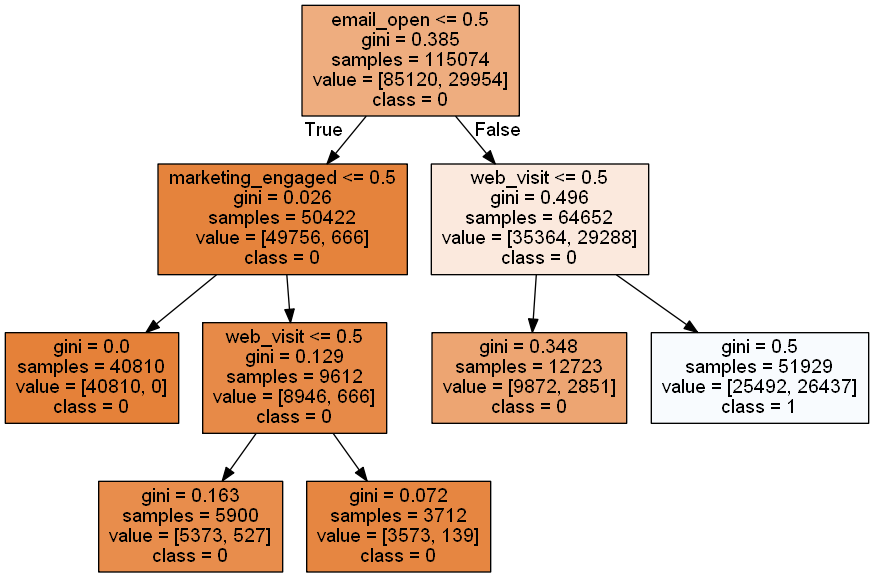

In [29]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

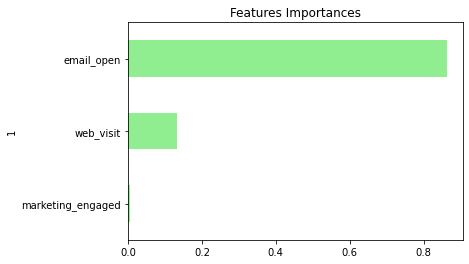

In [30]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)



### Study - Web Visit

In [31]:
X = bdf.loc[(bdf['effective_sale'] == 1),['email_open','webcast_attendee','marketing_engaged']]
X

,email_open,webcast_attendee,marketing_engaged
8,1,0,1
38,1,1,1
44,0,0,0
45,1,0,1
57,1,1,1
...,...,...,...
1721240,0,0,0
1721252,0,0,0
1721289,1,0,1
1721300,1,1,1


In [32]:
# Define target vector and look at how it's shaped
y = np.array(bdf.loc[(bdf['effective_sale'] == 1),'S_web_visit'])
y[:5]

array([1, 1, 0, 0, 1], dtype=int64)

#### Web Visit - Creating a train test split

In [33]:
# Splitting up the training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### Web Visit - Perform Decision Tree model

In [34]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train, y_train)

# Making predictions using the testing data
# This is for the evaluation process
predictions = model.predict(X_test)

#### Web Visit - Model Evaluations

In [35]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [36]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15485,4230
Actual 1,1215,17428


Accuracy Score : 0.8580478648521821
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     19715
           1       0.80      0.93      0.86     18643

    accuracy                           0.86     38358
   macro avg       0.87      0.86      0.86     38358
weighted avg       0.87      0.86      0.86     38358



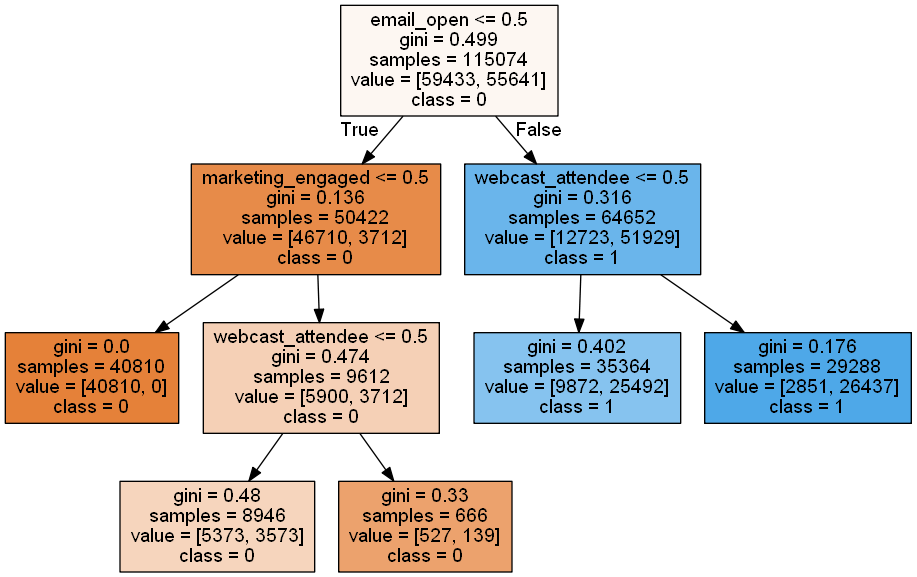

In [37]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

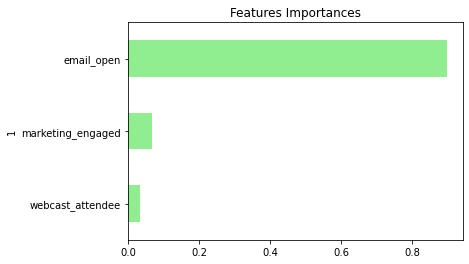

In [38]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)



### Study - Marketing Engaged

In [39]:
X = bdf.loc[(bdf['effective_sale'] == 1),['email_open','webcast_attendee','web_visit']]
X

,email_open,webcast_attendee,web_visit
8,1,0,1
38,1,1,1
44,0,0,0
45,1,0,0
57,1,1,1
...,...,...,...
1721240,0,0,0
1721252,0,0,0
1721289,1,0,1
1721300,1,1,0


In [40]:
# Define target vector and look at how it's shaped
y = np.array(bdf.loc[(bdf['effective_sale'] == 1),'S_marketing_engaged'])
y[:5]

array([1, 1, 0, 1, 1], dtype=int64)

#### Marketing Engaged - Creating a train test split

In [41]:
# Splitting up the training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### Marketing Engaged - Perform Decision Tree model

In [42]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train, y_train)

# Making predictions using the testing data
# This is for the evaluation process
predictions = model.predict(X_test)

#### Marketing Engaged- Model Evaluations

In [43]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [44]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13555,0
Actual 1,1750,23053


Accuracy Score : 0.9543771833776526
Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13555
           1       1.00      0.93      0.96     24803

    accuracy                           0.95     38358
   macro avg       0.94      0.96      0.95     38358
weighted avg       0.96      0.95      0.95     38358



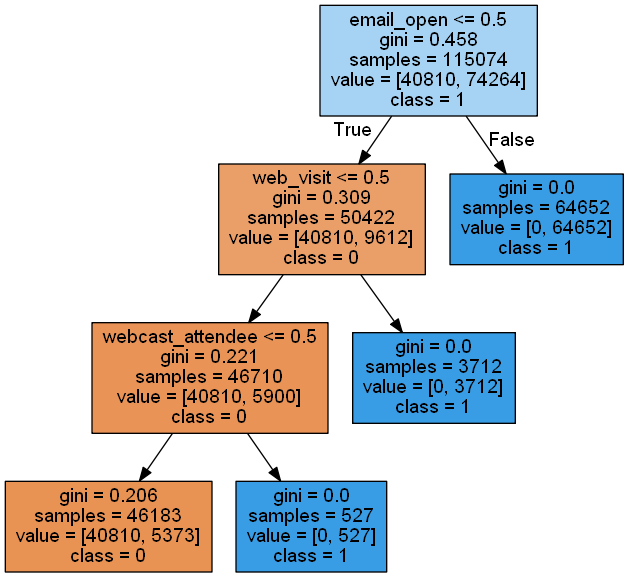

In [45]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

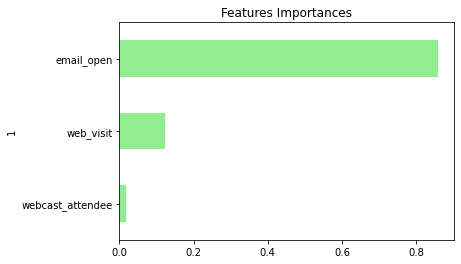

In [46]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)



---
## Summary

**Important: we are NOT running a forecast or prediction with this machine learning model.**

- All the variables are controllable in this model since they are drivers.
- e.g. if we have an email opened, we can decide what steps to take next
- This model will show all the scenarios of sales signals
- Email open is showing as the most important variables across all the trees.
- e.g. when we have someone visited our website, what should we do?
- e.g. when we have someone visited our website, and engaged in our marketing material; it means the likihood of a sale is low based on our previous experience in sales. (the pathway simply doe not show up in the decision tree)